In [1]:
import os,sys
source_file_path=os.environ['HOME']+'/work'+'/efficientnetv2/'
os.chdir(source_file_path)
print(source_file_path)

/home/ma-user/work/efficientnetv2/


In [2]:
batch_size = 18                             # 批量大小
image_size = 224                            # 训练图像空间大小
num_epochs = 50                             # 训练周期数
# lr = 0.001                                  # 学习率
momentum = 0.9                              # momentum
workers = 12                                 # 并行线程个数

In [3]:
!pip install mindvision
!pip install opencv-python install "opencv-python-headless<4.3"

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.0/33.0 MB 44.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 39.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 28.8 MB/s eta 0:00:00
  Created wheel for ml-collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=20699ca1d01f79f1530406b9e545df9b6715ede3410f31b73ecc421df48e4456
  Stored in directory: /home/ma-user/.cache/pip/wheels/99/c3/28/3b58c360d4ed678c4f045bc99e3ac99b1e0f7ca45f1da41437
Successfully built ml-collections

[notice] A new release of pip available: 22.1.2 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: http://repo.myhuaweicloud.

In [4]:
import mindspore as ms
import mindspore.dataset as ds
import mindspore.dataset.vision.c_transforms as vision
from mindspore import Model, Tensor, context, load_checkpoint, load_param_into_net


# 数据集目录路径
data_path_train = "./dataset/train/"
data_path_val = "./dataset/val/"

# 创建训练数据集

def create_dataset_canidae(dataset_path, usage):
    """数据加载"""
    data_set = ds.ImageFolderDataset(dataset_path,
                                     num_parallel_workers=workers,
                                     shuffle=True,)

    # 数据增强操作
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    # scale = 32
    image_size = [224,224]

    # if usage == "train":
        # Define map operations for training dataset
    trans = [
            vision.Decode(),
            vision.Resize(image_size),
            vision.Normalize(mean=mean, std=std),
            vision.HWC2CHW()
        ]
    # else:
    #     # Define map operations for inference dataset
    #     trans = [
    #         vision.Decode(),
    #         vision.Resize(image_size + scale),
    #         vision.CenterCrop(image_size),
    #         vision.Normalize(mean=mean, std=std),
    #         vision.HWC2CHW()
    #     ]


    # 数据映射操作
    data_set = data_set.map(
        operations=trans,
        input_columns='image',
        num_parallel_workers=workers)


    # 批量操作
    data_set = data_set.batch(batch_size)

    return data_set


dataset_train = create_dataset_canidae(data_path_train, "train")
step_size_train = dataset_train.get_dataset_size()

dataset_val = create_dataset_canidae(data_path_val, "val")
step_size_val = dataset_val.get_dataset_size()

### 数据集可视化

从`mindspore.dataset.ImageFolderDataset`接口中加载的训练数据集返回值为字典，用户可通过 `create_dict_iterator` 接口创建数据迭代器，使用 `next` 迭代访问数据集。本章中 `batch_size` 设为18，所以使用 `next` 一次可获取18个图像及标签数据。

In [5]:
data = next(dataset_train.create_dict_iterator())
images = data["image"]
labels = data["label"]

print("Tensor of image", images.shape)
print("Labels:", labels)

Tensor of image (18, 3, 224, 224)
Labels: [ 3  9 32 39 47 10 33 50 33 51 31 24 36 11 42  7 39  2]


对获取到的图像及标签数据进行可视化，标题为图像对应的label名称。

3
9
32
39


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: SimHei


47
10


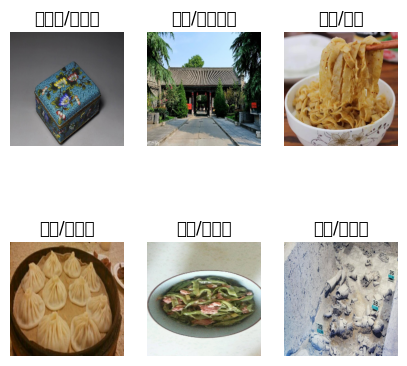

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from pylab import mpl
import cv2
# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["SimHei"]
# class_name对应label，按文件夹字符串从小到大的顺序标记label
class_name = {0 : '工艺品/仿唐三彩',1 : '工艺品/仿宋木叶盏', 2 : '工艺品/布贴绣', 3 : '工艺品/景泰蓝', 4 : '工艺品/木马勺脸谱', 5 : '工艺品/柳编', 6 : '工艺品/葡萄花鸟纹银香囊', 7 : '工艺品/西安剪纸', 8 : '工艺品/陕历博唐妞系列', 9 : '景点/关中书院', 10: '景点/兵马俑', 11: '景点/南五台', 12: '景点/大兴善寺', 13: '景点/大观楼', 14: '景点/大雁塔', 15: '景点/小雁塔', 16: '景点/未央宫城墙遗址', 17: '景点/水陆庵壁塑', 18: '景点/汉长安城遗址', 19: '景点/西安城墙', 20: '景点/钟楼', 21: '景点/长安华严寺', 22: '景点/阿房宫遗址', 23: '民俗/唢呐', 24: '民俗/皮影', 25: '特产/临潼火晶柿子', 26: '特产/山茱萸', 27: '特产/玉器', 28: '特产/阎良甜瓜', 29: '特产/陕北红小豆', 30: '特产/高陵冬枣', 31: '美食/八宝玫瑰镜糕', 32: '美食/凉皮', 33: '美食/凉鱼', 34: '美食/德懋恭水晶饼', 35: '美食/搅团', 36: '美食/枸杞炖银耳', 37: '美食/柿子饼', 38: '美食/浆水面', 39: '美食/灌汤包', 40: '美食/烧肘子', 41: '美食/石子饼', 42: '美食/神仙粉', 43: '美食/粉汤羊血', 44: '美食/羊肉泡馍', 45: '美食/肉夹馍', 46: '美食/荞面饸饹', 47: '美食/菠菜面', 48: '美食/蜂蜜凉粽子', 49: '美食/蜜饯张口酥饺', 50: '美食/西安油茶', 51: '美食/贵妃鸡翅', 52: '美食/醪糟', 53: '美食/金线油塔'}
plt.figure(figsize=(5, 5))
for i in range(6):
    # 获取图像及其对应的label
    data_image = images[i].asnumpy()
    data_label = labels[i]
    print(data_label)
    # 处理图像供展示使用
    data_image = np.transpose(data_image, (1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    data_image = std * data_image + mean
    data_image = np.clip(data_image, 0, 1)
    # 显示图像
    plt.subplot(2, 3, i+1)
    plt.imshow(data_image)
    plt.title(class_name[int(labels[i].asnumpy())])
    plt.axis("off")

plt.show()

In [7]:
import os

from mindspore import Model, nn, context, set_seed
from mindspore.train.callback import ModelCheckpoint, CheckpointConfig, LossMonitor, TimeMonitor

from src.args import args
from src.tools.callback import ModelArtsCallBack
from src.tools.cell import cast_amp
from src.tools.criterion import get_criterion, NetWithLoss
from src.tools.get_misc import get_dataset, set_device, get_model, pretrained, get_train_one_step
from src.tools.optimizer import get_optimizer
args.num_classes = 54
net = get_model(args)
if args.pretrained:
        pretrained(args, net)

==> Creating model 'effnetv2_s'
=> loading pretrained weights from './efficientnets_imagenet22k.ckpt'
==> removing classifier.weight with shape (21843, 1280)
==> removing classifier.bias with shape (21843,)


[WARNING] ME(1314:281472838498880,MainProcess):2023-01-14-09:26:58.819.012 [mindspore/train/serialization.py:648] For 'load_param_into_net', 2 parameters in the 'net' are not loaded, because they are not in the 'parameter_dict', please check whether the network structure is consistent when training and loading checkpoint.
[WARNING] ME(1314:281472838498880,MainProcess):2023-01-14-09:26:58.820.846 [mindspore/train/serialization.py:650] classifier.weight is not loaded.
[WARNING] ME(1314:281472838498880,MainProcess):2023-01-14-09:26:58.821.818 [mindspore/train/serialization.py:650] classifier.bias is not loaded.


In [ ]:
from mindspore.nn import SoftmaxCrossEntropyWithLogits
from mindspore.train.loss_scale_manager import FixedLossScaleManager
from mindspore.nn import Momentum
from mindvision.engine.callback import ValAccMonitor
set_seed(1)
num_epochs = 150
step_size = step_size_train
lr = nn.cosine_decay_lr(min_lr=0.00001, max_lr=0.001, total_step=step_size * num_epochs,
                        step_per_epoch=step_size, decay_epoch=num_epochs)
# 定义优化器和损失函数
opt = nn.Momentum(params=net.trainable_params(), learning_rate=lr, momentum=0.9)
loss = nn.SoftmaxCrossEntropyWithLogits(sparse=True, reduction='mean')
# 实例化模型
model = Model(net, loss, opt, metrics={"Accuracy": nn.Accuracy()})
# 模型训练
model.train(num_epochs, dataset_train, callbacks=[ValAccMonitor(model, dataset_val, num_epochs)])

--------------------
Epoch: [  1 /  150], Train Loss: [0.371], Accuracy:  0.851
--------------------
Epoch: [  2 /  150], Train Loss: [0.610], Accuracy:  0.885
--------------------
Epoch: [  3 /  150], Train Loss: [0.191], Accuracy:  0.919
--------------------
Epoch: [  4 /  150], Train Loss: [0.162], Accuracy:  0.922
--------------------
Epoch: [  5 /  150], Train Loss: [0.153], Accuracy:  0.935
--------------------
Epoch: [  6 /  150], Train Loss: [0.077], Accuracy:  0.932
--------------------
Epoch: [  7 /  150], Train Loss: [0.147], Accuracy:  0.934
--------------------
Epoch: [  8 /  150], Train Loss: [0.053], Accuracy:  0.934
--------------------
Epoch: [  9 /  150], Train Loss: [0.003], Accuracy:  0.941
--------------------
Epoch: [ 10 /  150], Train Loss: [0.009], Accuracy:  0.943
--------------------
Epoch: [ 11 /  150], Train Loss: [0.017], Accuracy:  0.944
--------------------
Epoch: [ 12 /  150], Train Loss: [0.026], Accuracy:  0.944
--------------------
Epoch: [ 13 /  150]

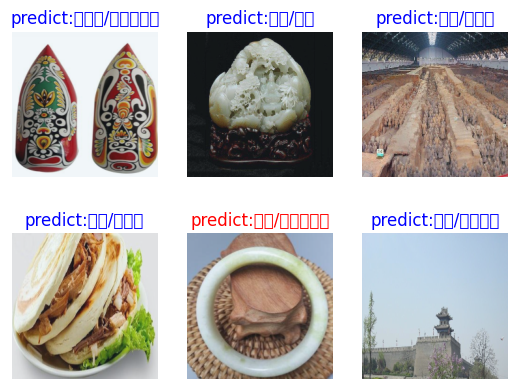

In [9]:

import matplotlib.pyplot as plt
from mindspore import Tensor
import numpy as np
# from mindspore import load_checkpoint, load_param_into_net


class_name = {0 : '工艺品/仿唐三彩',1 : '工艺品/仿宋木叶盏', 2 : '工艺品/布贴绣', 3 : '工艺品/景泰蓝', 4 : '工艺品/木马勺脸谱', 5 : '工艺品/柳编', 6 : '工艺品/葡萄花鸟纹银香囊', 7 : '工艺品/西安剪纸', 8 : '工艺品/陕历博唐妞系列', 9 : '景点/关中书院', 10: '景点/兵马俑', 11: '景点/南五台', 12: '景点/大兴善寺', 13: '景点/大观楼', 14: '景点/大雁塔', 15: '景点/小雁塔', 16: '景点/未央宫城墙遗址', 17: '景点/水陆庵壁塑', 18: '景点/汉长安城遗址', 19: '景点/西安城墙', 20: '景点/钟楼', 21: '景点/长安华严寺', 22: '景点/阿房宫遗址', 23: '民俗/唢呐', 24: '民俗/皮影', 25: '特产/临潼火晶柿子', 26: '特产/山茱萸', 27: '特产/玉器', 28: '特产/阎良甜瓜', 29: '特产/陕北红小豆', 30: '特产/高陵冬枣', 31: '美食/八宝玫瑰镜糕', 32: '美食/凉皮', 33: '美食/凉鱼', 34: '美食/德懋恭水晶饼', 35: '美食/搅团', 36: '美食/枸杞炖银耳', 37: '美食/柿子饼', 38: '美食/浆水面', 39: '美食/灌汤包', 40: '美食/烧肘子', 41: '美食/石子饼', 42: '美食/神仙粉', 43: '美食/粉汤羊血', 44: '美食/羊肉泡馍', 45: '美食/肉夹馍', 46: '美食/荞面饸饹', 47: '美食/菠菜面', 48: '美食/蜂蜜凉粽子', 49: '美食/蜜饯张口酥饺', 50: '美食/西安油茶', 51: '美食/贵妃鸡翅', 52: '美食/醪糟', 53: '美食/金线油塔'}


def visualize_model(best_ckpt_path, val_ds):
    # num_class = 54  # 对狼和狗图像进行二分类
    # net = resnet101(num_class)
    # 加载模型参数
    param_dict = load_checkpoint(best_ckpt_path)
    load_param_into_net(net, param_dict)
    model = Model(net)
    # 加载验证集的数据进行验证
    data = next(val_ds.create_dict_iterator())
    images = data["image"].asnumpy()
    labels = data["label"].asnumpy()
    # 预测图像类别
    output = model.predict(Tensor(data['image']))
    pred = np.argmax(output.asnumpy(), axis=1)

    # 显示图像及图像的预测值
    plt.figure()
    for i in range(1, 7):
        plt.subplot(2, 3, i)
        # 若预测正确，显示为蓝色；若预测错误，显示为红色
        color = 'blue' if pred[i - 1] == labels[i - 1] else 'red'
        plt.title('predict:{}'.format(class_name[pred[i - 1]]), color=color)
        picture_show = np.transpose(images[i - 1], (1, 2, 0))
        mean = np.array([0.4914, 0.4822, 0.4465])
        std = np.array([0.2023, 0.1994, 0.2010])
        picture_show = std * picture_show + mean
        picture_show = np.clip(picture_show, 0, 1)
        plt.imshow(picture_show)
        plt.axis('off')

    plt.show()

# 使用测试数据集进行验证
visualize_model('best_964.ckpt', dataset_val)


#### 训练和评估

训练并评估网络，且在训练完成后，保存评估精度最高的ckpt文件(resnet50-best.ckpt)到当前路径的/BestCheckpoint下，保存路径和ckpt文件名可自行调整。

In [10]:
import os
import cv2
import mindspore
class_name = {0 : '工艺品/仿唐三彩',1 : '工艺品/仿宋木叶盏', 2 : '工艺品/布贴绣', 3 : '工艺品/景泰蓝', 4 : '工艺品/木马勺脸谱', 5 : '工艺品/柳编', 6 : '工艺品/葡萄花鸟纹银香囊', 7 : '工艺品/西安剪纸', 8 : '工艺品/陕历博唐妞系列', 9 : '景点/关中书院', 10: '景点/兵马俑', 11: '景点/南五台', 12: '景点/大兴善寺', 13: '景点/大观楼', 14: '景点/大雁塔', 15: '景点/小雁塔', 16: '景点/未央宫城墙遗址', 17: '景点/水陆庵壁塑', 18: '景点/汉长安城遗址', 19: '景点/西安城墙', 20: '景点/钟楼', 21: '景点/长安华严寺', 22: '景点/阿房宫遗址', 23: '民俗/唢呐', 24: '民俗/皮影', 25: '特产/临潼火晶柿子', 26: '特产/山茱萸', 27: '特产/玉器', 28: '特产/阎良甜瓜', 29: '特产/陕北红小豆', 30: '特产/高陵冬枣', 31: '美食/八宝玫瑰镜糕', 32: '美食/凉皮', 33: '美食/凉鱼', 34: '美食/德懋恭水晶饼', 35: '美食/搅团', 36: '美食/枸杞炖银耳', 37: '美食/柿子饼', 38: '美食/浆水面', 39: '美食/灌汤包', 40: '美食/烧肘子', 41: '美食/石子饼', 42: '美食/神仙粉', 43: '美食/粉汤羊血', 44: '美食/羊肉泡馍', 45: '美食/肉夹馍', 46: '美食/荞面饸饹', 47: '美食/菠菜面', 48: '美食/蜂蜜凉粽子', 49: '美食/蜜饯张口酥饺', 50: '美食/西安油茶', 51: '美食/贵妃鸡翅', 52: '美食/醪糟', 53: '美食/金线油塔'}
def _crop_center(img, cropx, cropy):
    y, x, _ = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx, :]


def _normalize(img, mean, std):
    # This method is borrowed from:
    #   https://github.com/open-mmlab/mmcv/blob/master/mmcv/image/photometric.py
    assert img.dtype != np.uint8
    mean = np.float64(mean.reshape(1, -1))
    stdinv = 1 / np.float64(std.reshape(1, -1))
    cv2.cvtColor(img, cv2.COLOR_BGR2RGB, img)
    cv2.subtract(img, mean, img)
    cv2.multiply(img, stdinv, img)
    return img


def data_preprocess(img_path):
    img = cv2.imread(img_path, 1)
    img = cv2.resize(img, (256, 256))
    img = _crop_center(img, 224, 224)
    mean = [0.485 * 255, 0.456 * 255, 0.406 * 255]
    std = [0.229 * 255, 0.224 * 255, 0.225 * 255]
    img = _normalize(img.astype(np.float32), np.asarray(mean), np.asarray(std))
    img = img.transpose(2, 0, 1)

    return img


def resnet50_predict(class_num):
    num_class = class_num
    local_data_path = '/home/ma-user/work/ResNet-50/test'
    local_ckpt_path = r'./best_964.ckpt'

    # set graph mode and parallel mode
    context.set_context(mode=context.GRAPH_MODE, device_target='Ascend', save_graphs=False)

    
    # load checkpoint into net
    # net = resnet101(num_class)
    param_dict = load_checkpoint(local_ckpt_path)
    load_param_into_net(net, param_dict)
    net.set_train(False)

    # preprocess the image
    images = os.listdir(local_data_path)
    images.sort(key=lambda x:int(x.split('.')[0]))
    label_dict = []
    for img in images:
        print(img)
        img = data_preprocess(os.path.join(local_data_path, img))
        # predict model
        res = net(Tensor(img.reshape((1, 3, 224, 224)), mindspore.float32)).asnumpy()
        print(res[0].argmax())
        predict_label = int(res[0].argmax())
        print(class_name[predict_label])
        label_dict.append(predict_label)
    with open('./result.txt','a') as t:
        for a in label_dict:
            t.write(str(a)+'\n')
    t.close()

In [11]:
if __name__ == '__main__':
    resnet50_predict(54)
    print('ResNet50 prediction success!')

1.jpg
0
工艺品/仿唐三彩
2.jpg
15
景点/小雁塔
3.jpg
15
景点/小雁塔
4.jpg
15
景点/小雁塔
5.jpg
15
景点/小雁塔
6.jpg
15
景点/小雁塔
7.jpg
16
景点/未央宫城墙遗址
8.jpg
16
景点/未央宫城墙遗址
9.jpg
16
景点/未央宫城墙遗址
10.jpg
16
景点/未央宫城墙遗址
11.jpg
16
景点/未央宫城墙遗址
12.jpg
3
工艺品/景泰蓝
13.jpg
3
工艺品/景泰蓝
14.jpg
3
工艺品/景泰蓝
15.jpg
3
工艺品/景泰蓝
16.jpg
3
工艺品/景泰蓝
17.jpg
17
景点/水陆庵壁塑
18.jpg
17
景点/水陆庵壁塑
19.jpg
17
景点/水陆庵壁塑
20.jpg
17
景点/水陆庵壁塑
21.jpg
17
景点/水陆庵壁塑
22.jpg
18
景点/汉长安城遗址
23.jpg
18
景点/汉长安城遗址
24.jpg
18
景点/汉长安城遗址
25.jpg
18
景点/汉长安城遗址
26.jpg
18
景点/汉长安城遗址
27.jpg
19
景点/西安城墙
28.jpg
19
景点/西安城墙
29.jpg
19
景点/西安城墙
30.jpg
19
景点/西安城墙
31.jpg
19
景点/西安城墙
32.jpg
20
景点/钟楼
33.jpg
20
景点/钟楼
34.jpg
20
景点/钟楼
35.jpg
20
景点/钟楼
36.jpg
20
景点/钟楼
37.jpg
21
景点/长安华严寺
38.jpg
21
景点/长安华严寺
39.jpg
21
景点/长安华严寺
40.jpg
21
景点/长安华严寺
41.jpg
21
景点/长安华严寺
42.jpg
22
景点/阿房宫遗址
43.jpg
22
景点/阿房宫遗址
44.jpg
22
景点/阿房宫遗址
45.jpg
22
景点/阿房宫遗址
46.jpg
22
景点/阿房宫遗址
47.jpg
23
民俗/唢呐
48.jpg
23
民俗/唢呐
49.jpg
23
民俗/唢呐
50.jpg
23
民俗/唢呐
51.jpg
23
民俗/唢呐
52.jpg
24
民俗/皮影
53.jpg
24
民俗/皮影
54.jpg
24
民俗/皮影
55.jpg
24
民俗/皮影
56.jpg
24
民俗/皮影
5

In [ ]:
import moxing as mox
mox.file.copy('/home/ma-user/work/efficientnetv2', 'obs://huxian456/efficientnetv2/')

INFO:root:Using MoXing-v2.0.1.rc0.ffd1c0c8-ffd1c0c8
INFO:root:Using OBS-Python-SDK-3.20.9.1
